# AUTOENCODER MICRO SPRITE GENERATOR
Tests architecture for micro sprite generation using autoencoders, variational autoencoders, and vq-vaes

---

### Setup

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import os
import json
from matplotlib.colors import ListedColormap

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU
from tensorflow.keras.models import Model


%matplotlib inline

CONSTANTS and GLOBALS

In [3]:
# CONSTANT VARIABLES

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


GENERAL UTILITY FUNCTIONS

In [4]:
##  RENDER FUNCTIONS  ##

# show a single sprite - using a specified palette (form (NxN))
def showSprPalette(spr,palette=PICO_PALETTE):
    #set the colormap
    colormap = ListedColormap(palette,N=len(palette))

    #show the sprite
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(spr.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
    plt.show()


# show a list of sprites - using a specified palette (form Ax(NxN))
def showMultiSprPalette(sprs,palette=PICO_PALETTE,text='',textArr=None):
    #set the colormap
    colormap = ListedColormap(palette,N=len(palette))

    #show sprites (8 per row)
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(sprs):
        plt.subplot(int(len(sprs) / col) + 1, col, i + 1)
        plt.imshow(im.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
        plt.axis('off')

        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(sprs),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(sprs),col)//2):
                plt.title(text.upper())
    plt.show()

# show a single sprite - using RGB (form (NxNx3))
def showSprRGB(spr):
    #show the sprite
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(spr.squeeze())
    plt.show()

# show a list of sprites - using RGB (form Ax(NxNx3))
def showMultiSprRGB(sprs,text='',textArr=None):
    #show sprites (8 per row)
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(sprs):
        plt.subplot(int(len(sprs) / col) + 1, col, i + 1)
        plt.imshow(im.squeeze())
        plt.axis('off')

        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(sprs),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(sprs),col)//2):
                plt.title(text.upper())
    plt.show()




##  DATA PROCESSING FUNCTIONS  ##

# encode a sprite to one-hot array based on a palette (form (NxN) => (NxNxP)))
def encodeSpr1H(s,channels=len(PICO_PALETTE)):
    spr3d = np.zeros((s.shape[0],s.shape[1],channels))
    for r in range(s.shape[0]):
        for c in range(s.shape[1]):
            v = s[r][c]
            spr3d[r][c][v] = 1
    return spr3d
    
#convert 3d encoded channel map into 2d array format
def decodeSpr1H(s3c):
    return np.argmax(s3c,axis=2)
    

IMPORT DATASETS

Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


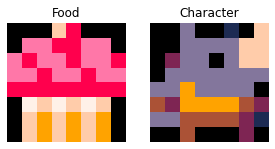

In [11]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)
good_pico_sheets = np.load('../data/rip_data/good_pico_sheets.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

### GENERATIVE MODEL EXPERIMENT 

#### Autoencoder Experiments
Needs to overfit for such a small dataset (train 350 epochs or so)

In [6]:
TRAIN_AE = False
AE_MODEL_NAME = "pico_ae-[char100p]-350"  #if not retraining, specify the model name to load

In [7]:
##  BASIC AUTOENCODER  ##

class PICOAutoencoder(Model):
    def __init__(self,in_shape,show_summary=False):
        super(PICOAutoencoder, self).__init__()
        self.encoder = Sequential([
            InputLayer(input_shape=in_shape),
            Conv2D(64, (2,2), strides=2, activation='relu', padding='same'),
            Conv2D(32, (2,2), strides=2, activation='relu', padding='same'),
            Conv2D(16, (2,2), strides=2, activation='relu', padding='same')])

        self.decoder = Sequential([
            InputLayer(input_shape=self.encoder.output_shape[1:]),
            Conv2DTranspose(16, (2,2), strides=2, activation='relu', padding='same'),
            Conv2DTranspose(32, (2,2), strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, (2,2), strides=2, activation='relu', padding='same'),
            # Conv2D(in_shape[-1], (3,3), activation='sigmoid', padding='same')])
            Conv2D(in_shape[-1], (3,3), activation='softmax', padding='same')])
        

        if show_summary:
            print("== ENCODER ==")
            self.encoder.summary()
            print("")
            print("== DECODER ==")
            self.decoder.summary()
        

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def exportEnc(self, name):
        if not os.path.exists("../models/gen_models/autoencoders/"):
            os.mkdir("../models/gen_models/autoencoders/")
        self.encoder.save(f"../models/gen_models/autoencoders/{name}_encoder.h5")

    def exportDec(self, name):
        if not os.path.exists("../models/gen_models/autoencoders/"):
            os.mkdir("../models/gen_models/autoencoders/")
        self.decoder.save(f"../models/gen_models/autoencoders/{name}_decoder.h5")

    def importDec(self,name):
        self.decoder = load_model(f"../models/gen_models/autoencoders/{name}_decoder.h5")
        
    def importEnc(self,name):
        self.encoder = load_model(f"../models/gen_models/autoencoders/{name}_encoder.h5")

In [8]:
# setup the dataset
# pico_ae_dat = np.concatenate((pico_food_dat,pico_char_dat),axis=0)  # combine food and character datasets
pico_ae_dat = pico_char_dat

pico_ae_dat = np.array([encodeSpr1H(s) for s in pico_ae_dat])   # encode to 1-hot
np.random.shuffle(pico_ae_dat)                                  # shuffle the dataset
print(f"Autoencoder Dataset shape: {pico_ae_dat.shape}")

# setup the model
pico_ae_model = PICOAutoencoder((8,8,len(PICO_PALETTE)),True)
# pico_ae_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
pico_ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model (if TRAIN_AE is True) otherwise load the model
EPOCHS = 250
BATCH_SIZE = 16
if TRAIN_AE:
    h = pico_ae_model.fit(pico_ae_dat, pico_ae_dat, batch_size=BATCH_SIZE,epochs=EPOCHS,shuffle=True)

    #plot the accuracy over time
    plt.plot(h.history['accuracy'])
else:
    print(f"Loading model: {AE_MODEL_NAME}")
    pico_ae_model.importEnc(AE_MODEL_NAME)
    pico_ae_model.importDec(AE_MODEL_NAME)


Autoencoder Dataset shape: (100, 8, 8, 16)
== ENCODER ==
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 64)          4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 32)          8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 16)          2064      
                                                                 
Total params: 14,448
Trainable params: 14,448
Non-trainable params: 0
_________________________________________________________________

== DECODER ==
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 2, 2, 16)         1040      
 nspose)                

OSError: No file or directory found at ../models/gen_models/autoencoders/pico_ae-[char100p]-350_encoder.h5

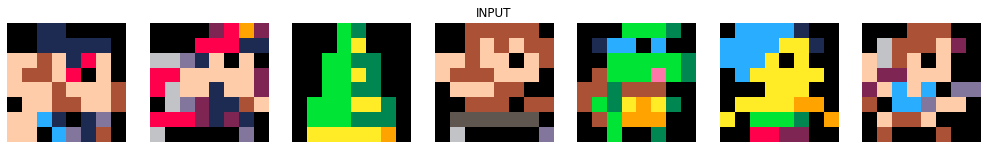

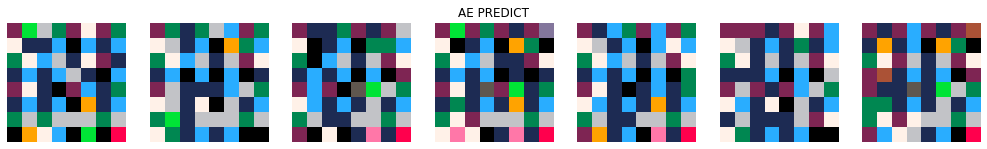

In [9]:
# test output
ae_test_set = random.choices(pico_ae_dat, k=7)
ae_test_set = np.array(ae_test_set)

showMultiSprPalette([decodeSpr1H(s) for s in ae_test_set],text='INPUT')
showMultiSprPalette([decodeSpr1H(s) for s in pico_ae_model.predict(ae_test_set,verbose=False)],text='AE PREDICT')


(7, 1, 1, 16)


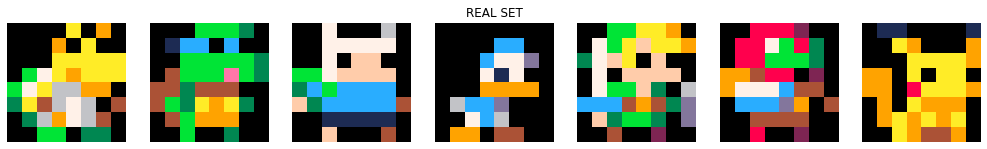

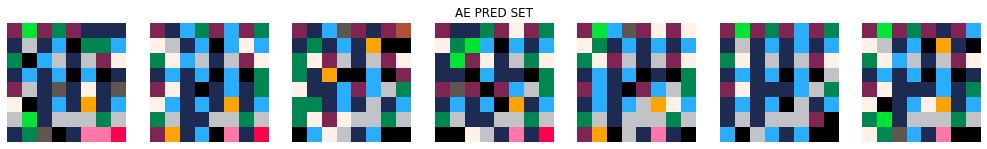

In [10]:
# random sampling

# show some final outputs from real data
real_set = [7,30,53,86,90,96,99]    
real_set_label = ['Koopa','Donatello','Finn','Dewey','Link','Samus','Pikachu']
real_oh_set = np.array([encodeSpr1H(s) for s in pico_char_dat[real_set]])

real_enc = pico_ae_model.encoder.predict(real_oh_set,verbose=False)
real_dec = pico_ae_model.decoder.predict(real_enc,verbose=False)

print(real_enc.shape)

showMultiSprPalette([pico_char_dat[i] for i in real_set],text='Real set')
showMultiSprPalette([decodeSpr1H(s) for s in real_dec],text='AE Pred set')


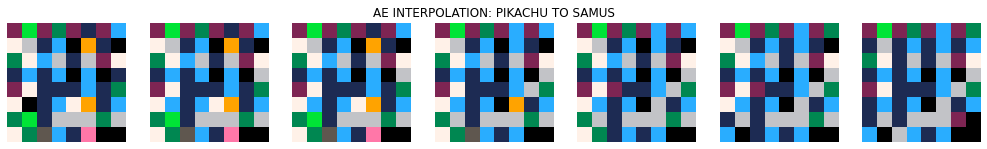

In [12]:
# shift from one character to another

def interpolateVec(v1,v2,steps):
    return [v1 + (v2-v1)*i/(steps-1) for i in range(steps)]

pick2 = random.sample(range(len(real_enc)), k=2)
inter_vec = interpolateVec(real_enc[pick2[0]],real_enc[pick2[1]],7) 
inter_pred = pico_ae_model.decoder.predict(np.array(inter_vec),verbose=False)
showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'AE Interpolation: {real_set_label[pick2[0]]} to {real_set_label[pick2[1]]}')


In [13]:
# compare between 2 groups of similar characters (ninja turtles + duck tales)
ninja_turtles = [30,31,32,33]
duck_tales = [84,85,86,87]

ninja_oh = np.array([encodeSpr1H(s) for s in pico_char_dat[ninja_turtles]])
duck_oh = np.array([encodeSpr1H(s) for s in pico_char_dat[duck_tales]])

ninja_enc = pico_ae_model.encoder.predict(ninja_oh,verbose=False)
duck_enc = pico_ae_model.encoder.predict(duck_oh,verbose=False)

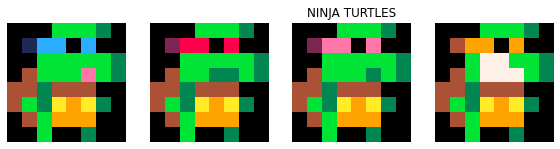

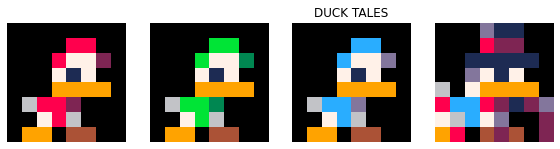

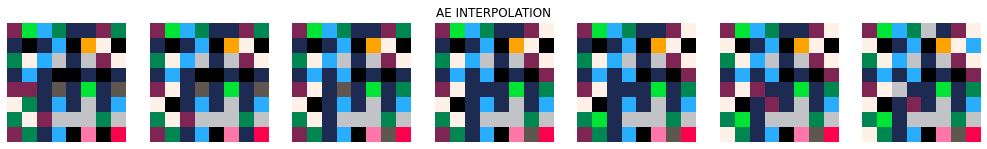

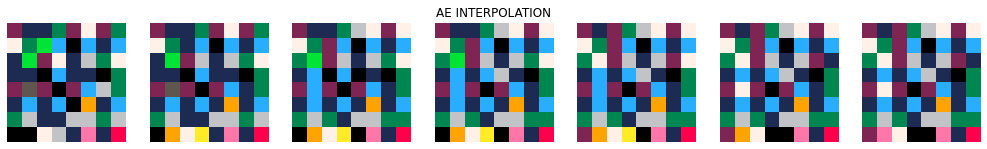

In [14]:
showMultiSprPalette([pico_char_dat[i] for i in ninja_turtles],text='Ninja Turtles')
showMultiSprPalette([pico_char_dat[i] for i in duck_tales],text='Duck Tales')

# interpolate between 2 random turtles and 2 random ducks
for a in [ninja_enc,duck_enc]:
    pick2 = random.sample(range(len(a)), k=2)
    inter_vec = interpolateVec(a[pick2[0]],a[pick2[1]],7)
    inter_pred = pico_ae_model.decoder.predict(np.array(inter_vec),verbose=False)
    showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'AE Interpolation')

In [15]:
# retrieve range of each element from the encoding vector 
enc_vec_set = pico_ae_model.encoder.predict(pico_ae_dat,verbose=False)
enc_vec_min_max = np.array([[np.min(enc_vec_set[:,:,i,j]),np.max(enc_vec_set[:,:,i,j])] for i in range(enc_vec_set.shape[2]) for j in range(enc_vec_set.shape[3])])

print(enc_vec_min_max.shape)  #should be (1,16,2)
print(enc_vec_min_max)
 


(16, 2)
[[0.         0.18962264]
 [0.         0.14624104]
 [0.         0.22656211]
 [0.         0.14641672]
 [0.         0.16984087]
 [0.         0.19369349]
 [0.00574096 0.31145176]
 [0.         0.08819252]
 [0.         0.1350397 ]
 [0.         0.02115469]
 [0.         0.18898655]
 [0.         0.26385584]
 [0.         0.29466426]
 [0.         0.11791695]
 [0.         0.16528377]
 [0.         0.26832682]]


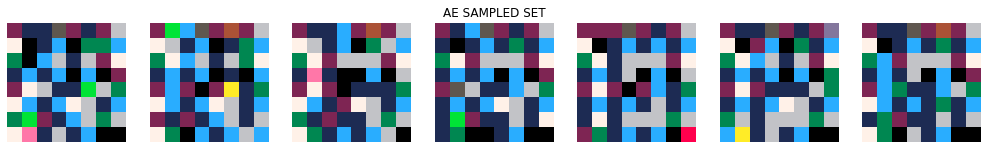

In [16]:
# sample from this space and show output
sample_set = []
for i in range(7):
    sample = np.array([np.random.uniform(enc_vec_min_max[i][0],enc_vec_min_max[i][1]) for i in range(16)])
    sample = np.expand_dims(sample,0)
    sample = np.expand_dims(sample,0)
    sample_set.append(sample)
sample_set = np.array(sample_set)
pred_samp_set = pico_ae_model.decoder.predict(sample_set,verbose=False)

showMultiSprPalette([decodeSpr1H(s) for s in pred_samp_set],text='AE Sampled set')


In [17]:
# export the model
pico_ae_model.exportEnc(f'pico_ae-[char100p]-{EPOCHS}')
pico_ae_model.exportDec(f'pico_ae-[char100p]-{EPOCHS}')

FileNotFoundError: [Errno 2] No such file or directory: '../models/gen_models/autoencoders/'

#### VARIATIONAL AUTOENCODER

In [18]:
# CONSTANTS

TRAIN_VAE = False
VAE_MODEL_NAME = "pico_vae-[char]-1000"
vae_dataset_type = "char"  #char, food, or both
EXPORT_VAE = False

VAE_Z = 16
VAE_EPOCHS = 750
VAE_BATCH_SIZE = 8

In [19]:
##  BASIC VAE  ##

class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    


class PICOVAE(Model):
    def __init__(self,nn_shape,zshape=16,show_summary=False):
        super(PICOVAE, self).__init__()
        
        self.spr_shape = nn_shape
        self.latent_dim = zshape
        
        #make the models
        self.makeEncoder(show_summary)
        self.makeDecoder(show_summary)
        
        
    #makes the encoder model for the VAE
    def makeEncoder(self,show_summary=False):
        
        #variational encoder
        enc_in = Input(shape=self.spr_shape)
        x = Conv2D(32, (2,2), activation=LeakyReLU(), padding='same', strides=2)(enc_in)
        x = Conv2D(64, (2,2), activation=LeakyReLU(), padding='same', strides=2)(x)
        x = Flatten()(x)
        x = Dense(16, activation='relu')(x)
        
        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        if show_summary:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self,show_summary=False):
        #normal decoder
        dec_in = Input(shape=(self.latent_dim,))
        y = Dense(2*2*64, activation="relu")(dec_in)  #product of output shape of encoder model
        y = Reshape((2,2,64))(y)  #output shape of encoder model before flattening
        y = Conv2DTranspose(64, kernel_size=2, strides=2, activation=LeakyReLU(), padding='same')(y)
        y = Conv2DTranspose(32, kernel_size=2, strides=2, activation=LeakyReLU(), padding='same')(y)
        dec_out = Conv2DTranspose(16, kernel_size=(3, 3), activation='softmax', padding='same')(y)  #softmax to get 1-hot encoding
        self.decoder = Model(dec_in, dec_out)

        
        if show_summary:
            self.decoder.summary()

    # training step for VAE
    def train_step(self, data):    
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)

            # reconstructive loss
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(data, reconstruction), axis=(1, 2)   #categorical cross-entropy because one-hot encoded
                )
            )

            # KL divergence loss
            kl = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl = tf.reduce_mean(tf.reduce_sum(kl, axis=1))

            #total loss
            tl = reconstruction_loss + kl
             
        #apply loss back to weights
        grads = tape.gradient(tl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl, "total loss": tl}
    
    #custom reconstruction function
    def reconstruct(self, data, **kwargs):
        _, _, z = self.encoder.predict(data,**kwargs)
        reconstruction = self.decoder.predict(z,**kwargs)
        return reconstruction
    
    #custom encoding function
    def decodeZ(self, z, **kwargs):
        return self.decoder.predict(z,**kwargs)
    

    #### EXPORT/IMPORT  ####
    
    def exportEnc(self, name):
        if not os.path.exists("../models/gen_models/vaes/"):
            os.mkdir("../models/gen_models/vaes/")
        self.encoder.save(f"../models/gen_models/vaes/{name}_encoder.h5")

    def exportDec(self, name):
        if not os.path.exists("../models/gen_models/vaes/"):
            os.mkdir("../models/gen_models/vaes/")
        self.decoder.save(f"../models/gen_models/vaes/{name}_decoder.h5")

    def importDec(self,name):
        self.decoder = load_model(f"../models/gen_models/vaes/{name}_decoder.h5",custom_objects={"Sampling":Sampling})
        
    def importEnc(self,name):
        self.encoder = load_model(f"../models/gen_models/vaes/{name}_encoder.h5",custom_objects={"Sampling":Sampling})

In [20]:
# setup the dataset
if vae_dataset_type == "char":
    pico_vae_dat = pico_char_dat
elif vae_dataset_type == "food":
    pico_vae_dat = pico_food_dat
else:
    pico_ae_dat = np.concatenate((pico_food_dat,pico_char_dat),axis=0)  # combine food and character datasets

pico_vae_dat = np.array([encodeSpr1H(s) for s in pico_vae_dat])   # encode to 1-hot
np.random.shuffle(pico_vae_dat)                                  # shuffle the dataset
print(f"Autoencoder Dataset shape: {pico_vae_dat.shape}")

# setup the VAE model
pico_vae_model = PICOVAE((8,8,len(PICO_PALETTE)),VAE_Z,True)

# train the model if TRAIN_VAE is True else load the model
if TRAIN_VAE:
    pico_vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    vaeh = pico_vae_model.fit(pico_vae_dat,epochs=VAE_EPOCHS,batch_size=VAE_BATCH_SIZE,shuffle=True,verbose=True)
else: 
    pico_vae_model.importEnc(VAE_MODEL_NAME)
    pico_vae_model.importDec(VAE_MODEL_NAME)


Autoencoder Dataset shape: (100, 8, 8, 16)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 8, 16)]   0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 4, 4, 32)     2080        ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 2, 2, 64)     8256        ['conv2d_4[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 256)          0           ['conv2d_5[0][0]']               
                                                 

OSError: No file or directory found at ../models/gen_models/vaes/pico_vae-[char]-1000_encoder.h5

In [21]:
pico_vae_dat.shape

(100, 8, 8, 16)

In [22]:
#plot the accuracy over time
if TRAIN_VAE:
    plt.plot(vaeh.history['recon loss'],label='recon loss')
    plt.plot(vaeh.history['kl loss'],label='kl loss')
    plt.plot(vaeh.history['total loss'],label='total loss')
    plt.legend()

    plt.show()

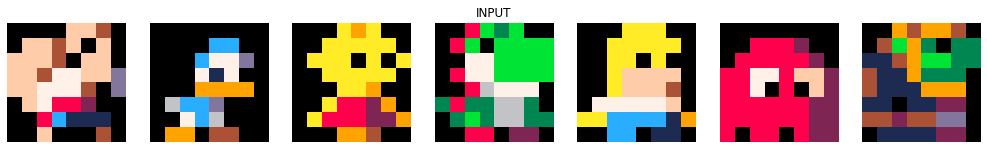

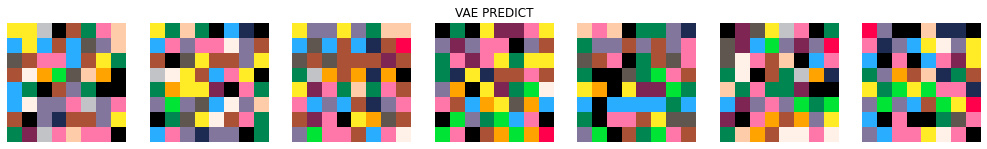

In [23]:
# test output
vae_test_set = random.choices(pico_vae_dat, k=7)
vae_test_set = np.array(vae_test_set)

showMultiSprPalette([decodeSpr1H(s) for s in vae_test_set],text='INPUT')
showMultiSprPalette([decodeSpr1H(s) for s in pico_vae_model.reconstruct(vae_test_set,verbose=False)],text='VAE PREDICT')


(7, 16)


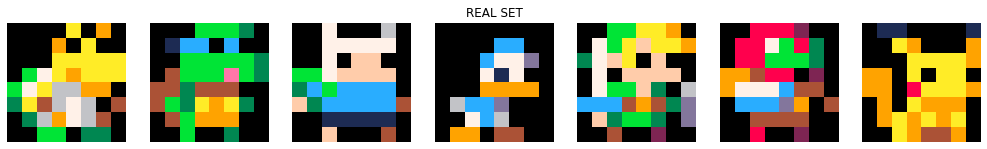

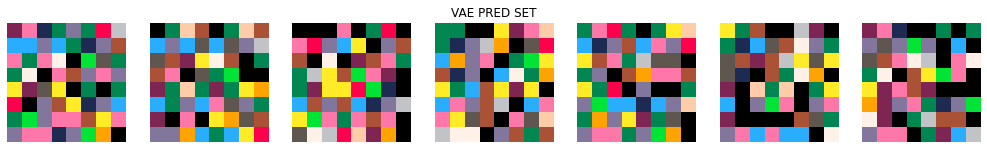

In [24]:
# random sampling

if vae_dataset_type == "char":
    # show some final outputs from real data
    real_set = [7,30,53,86,90,96,99]    
    real_set_label = ['Koopa','Donatello','Finn','Dewey','Link','Samus','Pikachu']
    real_oh_set = np.array([encodeSpr1H(s) for s in pico_char_dat[real_set]])

    _,_,real_enc_z = pico_vae_model.encoder.predict(real_oh_set,verbose=False)
    real_dec = pico_vae_model.decoder.predict(real_enc_z,verbose=False)

    print(real_enc_z.shape)

    showMultiSprPalette([pico_char_dat[i] for i in real_set],text='Real set')
    showMultiSprPalette([decodeSpr1H(s) for s in real_dec],text='VAE Pred set')

elif vae_dataset_type == "food":
    # show some final outputs from real data
    real_set = [2,6,7,11,27,38,63]    
    real_set_label = ['Banana', "Watermelon", "Cherry", "Beer", "Pretzel", "Blue Popsicle", "Pizza"]
    real_oh_set = np.array([encodeSpr1H(s) for s in pico_food_dat[real_set]])

    _,_,real_enc_z = pico_vae_model.encoder.predict(real_oh_set,verbose=False)
    real_dec = pico_vae_model.decoder.predict(real_enc_z,verbose=False)

    print(real_enc_z.shape)

    showMultiSprPalette([pico_food_dat[i] for i in real_set],text='Real set')
    showMultiSprPalette([decodeSpr1H(s) for s in real_dec],text='VAE Pred set')


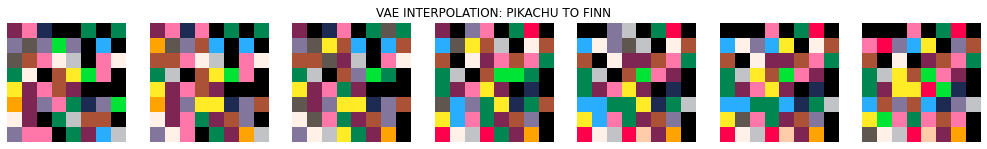

In [25]:
# shift from one character to another

def interpolateVec(v1,v2,steps):
    return [v1 + (v2-v1)*i/(steps-1) for i in range(steps)]

pick2 = random.sample(range(len(real_enc_z)), k=2)
inter_vec = interpolateVec(real_enc_z[pick2[0]],real_enc_z[pick2[1]],7) 
inter_pred = pico_vae_model.decodeZ(np.array(inter_vec),verbose=False)
showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'VAE Interpolation: {real_set_label[pick2[0]]} to {real_set_label[pick2[1]]}')


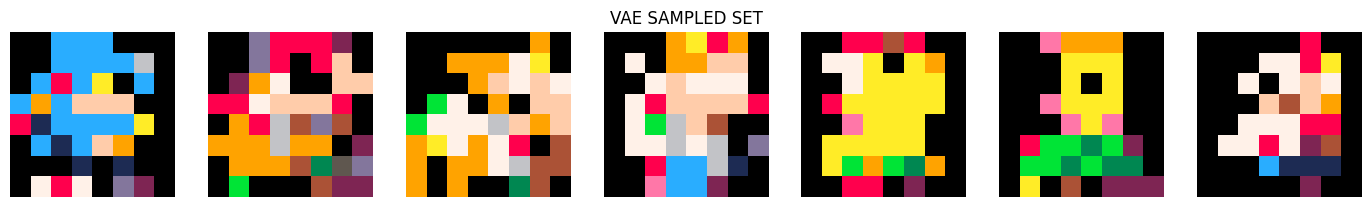

In [ ]:
# sample from this space and show output
sample_set = np.random.normal(0,1,size=(7,VAE_Z))

pred_samp_set = pico_vae_model.decoder.predict(sample_set,verbose=False)

showMultiSprPalette([decodeSpr1H(s) for s in pred_samp_set],text='VAE Sampled set')


In [ ]:
# export the model
if EXPORT_VAE:
    pico_vae_model.exportEnc(f'pico_vae-[{vae_dataset_type}]-{VAE_EPOCHS}')
    pico_vae_model.exportDec(f'pico_vae-[{vae_dataset_type}]-{VAE_EPOCHS}')

#### STUPID MODEL
Embedding to image model. That's it. Take a pretrained embedding network, train a model to output an image, that's it. Tim bet $25 this wouldn't work lmao

In [4]:
# IMPORT DOC2VEC

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
D2V_MODEL = Doc2Vec(documents, vector_size=128, window=2, min_count=1)

def wordEmb(txt):
    return D2V_MODEL.infer_vector(txt.split())

In [5]:
dewey = wordEmb("a duck with a blue hat")
huey = wordEmb("a duck with a red hat")
pikachu = wordEmb("a yellow electric mouse")

# get similarities between phrases by getting distances between word embeddings
print(f"COSINE SIM: {cos_sim([dewey,huey,pikachu])}")
print(f"EUCLIDEAN DIST: {[[np.linalg.norm(a-b) for a in [dewey,huey,pikachu]] for b in [dewey,huey,pikachu] ]}")


COSINE SIM: [[ 0.99999994  0.04852686  0.01285167]
 [ 0.04852686  1.         -0.13741206]
 [ 0.01285167 -0.13741206  1.        ]]
EUCLIDEAN DIST: [[0.0, 0.034984995, 0.035841152], [0.034984995, 0.0, 0.03873517], [0.035841152, 0.03873517, 0.0]]


In [6]:
# IMPORT SENTENCE BERT
from sentence_transformers import SentenceTransformer
SBERT_MODEL = SentenceTransformer('bert-base-nli-mean-tokens')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
dewey = sentEmb("a duck with a blue hat")
huey = sentEmb("a duck with a red hat")
pikachu = sentEmb("a yellow electric mouse")

# get similarities between phrases by getting distances between word embeddings
print(f"COSINE SIM: {cos_sim([dewey,huey,pikachu])}")
print(f"EUCLIDEAN DIST: {[[np.linalg.norm(a-b) for a in [dewey,huey,pikachu]] for b in [dewey,huey,pikachu] ]}")

COSINE SIM: [[1.0000001  0.6279819  0.23689032]
 [0.6279819  1.0000001  0.32165208]
 [0.23689032 0.32165208 0.99999994]]
EUCLIDEAN DIST: [[0.0, 14.473851, 20.830334], [14.473851, 0.0, 19.58954], [20.830334, 19.58954, 0.0]]


Conclusion: Use Sentence Transformers with Cosine Similarity metric

#### Make a model trained on word embedding to image

In [8]:
# import the labels for the PICO characters dataset
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# check association match
rand_char_i = random.randint(0,len(pico_char_labels))
rand_char = pico_char_labels[rand_char_i]
rand_char_img = pico_char_dat[rand_char_i]
print(f"{rand_char}")
showSprPalette(rand_char_img)

FileNotFoundError: [Errno 2] No such file or directory: '../data/rip_data/character_desc.txt'

In [9]:
# create the dataset (embheddings -> images)
pico_char_emb = SBERT_MODEL.encode(pico_char_labels)
pico_char_emb = np.array(pico_char_emb)

X_train = pico_char_emb
Y_train = np.array([encodeSpr1H(s) for s in pico_char_dat])

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")

NameError: name 'pico_char_labels' is not defined

In [36]:
# named after Tim's bet that this model was too simple lol
class FiveDollarModel(Model):
    def __init__(self,lv_shape,embedder=SBERT_MODEL):
        super(FiveDollarModel, self).__init__()
        self.embedder = embedder
        self.decoder = Sequential([
            InputLayer(input_shape=(lv_shape,)),
            # Dense(512,activation='relu'),
            Dense(256,activation='relu'),
            Reshape((2,2,64)),
            Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation='relu'),
            Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', activation='softmax')     # should output to a 8x8x16 one-hot encoded image
        ])
        
        self.decoder.summary()
        self.decoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # embeds the text and returns an image
    def txt2img(self,txt,uncode=True):
        emb = self.embedder.encode([txt])
        img = self.decoder.predict(np.array(emb),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img

In [37]:
# create and train the model
fdm = FiveDollarModel(X_train.shape[1])
fdm.decoder.fit(X_train,Y_train,epochs=150,verbose=1,shuffle=True,batch_size=16)

NameError: name 'X_train' is not defined

a blue turtle standing up


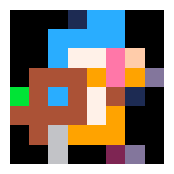

a woman with green hair


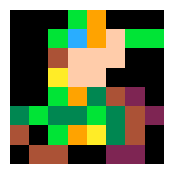

a duck with a yellow shirt


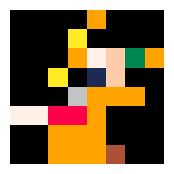

a white duck with a green outfit and a green hat


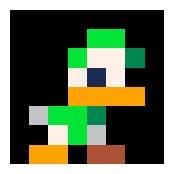

a yellow dog standing


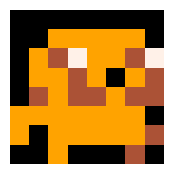

a man with a mustache and large pink nose dressed in yellow


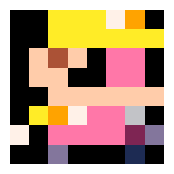

In [ ]:
# test the model on unseen data
test_char_desc = ["a blue turtle standing up", "a woman with green hair", "a duck with a yellow shirt"]
seen_char_desc = random.sample(list(pico_char_labels), k=3)

for desc in test_char_desc:
    print(desc)
    showSprPalette(fdm.txt2img(desc))

for desc in seen_char_desc:
    print(desc)
    showSprPalette(fdm.txt2img(desc))

#### Sanity generalization check with pure shapes

In [ ]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
import utils

# import importlib
# importlib.reload(utils)


# import the shapes spritesheet
shapes_spr_dat = utils.picoSS2np('../data/rip_data/colors.png')

(64, 8, 8)
blue small square


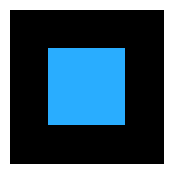

In [ ]:
colors = ["red", "orange", "yellow", "green", "blue", "purple", "pink", "white"]
size = ["large", "small"]
shapes = ["square", "triangle", "circle", "line"]
squares = shapes_spr_dat[0:16]
triangles = shapes_spr_dat[16:32]
circles = shapes_spr_dat[32:48]
lines = shapes_spr_dat[48:64]

#label and encode
shape_imgs = np.concatenate([squares,triangles,circles,lines],axis=0)
print(shape_imgs.shape) #should be (64,8,8)
shape_imgs_1h = np.array([encodeSpr1H(s) for s in shape_imgs])
shape_labels = np.array([f"{c} {z} {s}" for s in shapes for z in size for c in colors])

rand_shape = random.randint(0,len(shape_labels))
print(f"{shape_labels[rand_shape]}")
showSprPalette(shape_imgs[rand_shape])

Test Set: [13, 16, 42, 51]


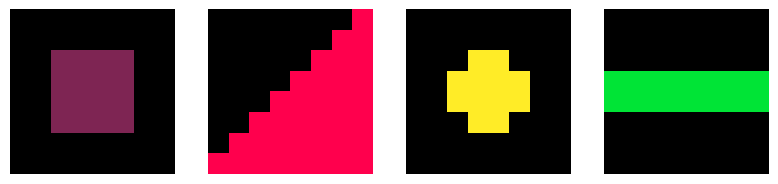

In [ ]:
# train on the shapes (leave out some for testing)
test_index = []
for i in range(4):
    test_index.append(random.randint(i*16,(i+1)*16))
train_index = [i for i in range(len(shape_labels)) if i not in test_index]

X_shape_train = np.array([sentEmb(l) for l in shape_labels[train_index]])
Y_shape_train = shape_imgs_1h[train_index]

X_shape_test = shape_labels[test_index]
Y_shape_test = shape_imgs_1h[test_index]

print(f"Test Set: {test_index}")
showMultiSprPalette([decodeSpr1H(i) for i in Y_shape_test])

In [ ]:
# like $5 model but bigger
class TenDollarModel(Model):
    def __init__(self,lv_shape,embedder=SBERT_MODEL):
        super(TenDollarModel, self).__init__()
        self.embedder = embedder
        self.decoder = Sequential([
            InputLayer(input_shape=(lv_shape,)),
            Dense(512,activation='relu'),
            Dense(256,activation='relu'),
            Dense(128,activation='relu'),
            Dense(64,activation='relu'),
            Reshape((1,1,64)),
            Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation=LeakyReLU()),
            Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation=LeakyReLU()),
            Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', activation='softmax')     # should output to a 8x8x16 one-hot encoded image
        ])
        
        self.decoder.summary()
        self.decoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # embeds the text and returns an image
    def txt2img(self,txt,uncode=True):
        emb = self.embedder.encode([txt])
        img = self.decoder.predict(np.array(emb),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 256)               196864    
                                                                 
 reshape_48 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_124 (Conv2  (None, 4, 4, 32)         8224      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_125 (Conv2  (None, 8, 8, 16)         2064      
 DTranspose)                                                     
                                                                 
Total params: 207,152
Trainable params: 207,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
8/8 [==============================

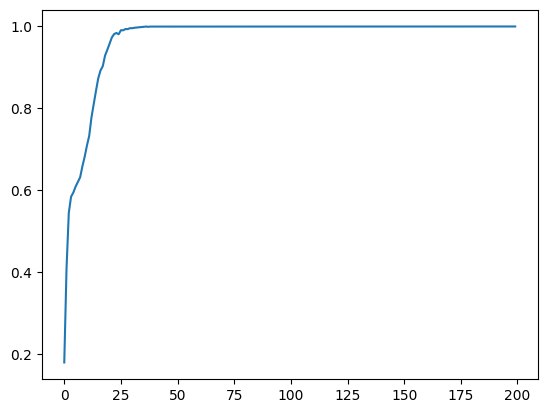

In [ ]:
# train the model
# shape_tdm = TenDollarModel(X_shape_train.shape[1])
# acc = shape_tdm.decoder.fit(X_shape_train,Y_shape_train,epochs=100,verbose=1,shuffle=True,batch_size=8)
shape_tdm = FiveDollarModel(X_shape_train.shape[1])
acc = shape_tdm.decoder.fit(X_shape_train,Y_shape_train,epochs=200,verbose=1,shuffle=True,batch_size=8)

# plot the accuracy
plt.plot(acc.history['accuracy'])

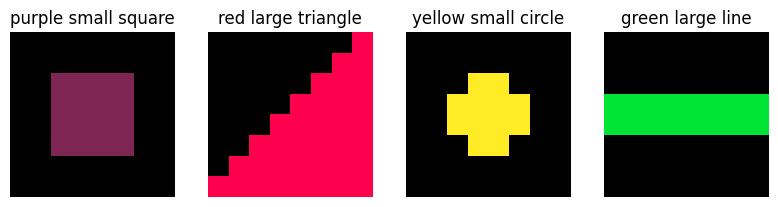

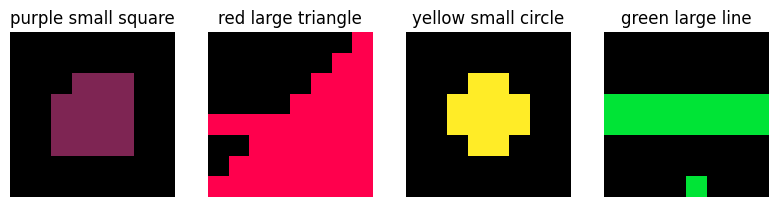

In [ ]:
# show the results of the test set
showMultiSprPalette([decodeSpr1H(s) for s in Y_shape_test], textArr=X_shape_test.tolist())
showMultiSprPalette([shape_tdm.txt2img(desc) for desc in X_shape_test],textArr=X_shape_test.tolist())

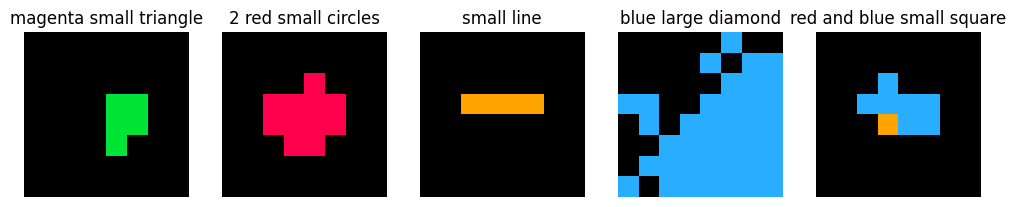

In [ ]:
crazy_desc = ['magenta small triangle', '2 red small circles', 'small line', 'blue large diamond', 'red and blue small square']
showMultiSprPalette([shape_tdm.txt2img(desc) for desc in crazy_desc],textArr=crazy_desc)


#### Emoji Dataset Experiment

(8,)


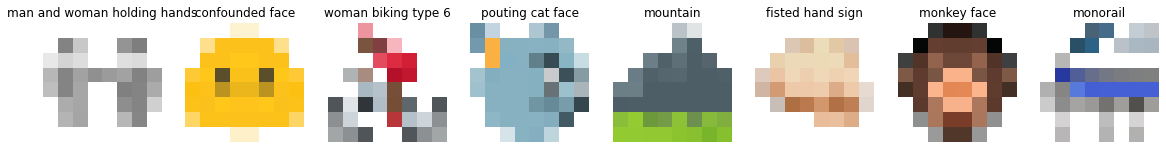

In [10]:
#import the icons dataset from numpy
icons50 = np.load('../data/sprite_data/icon_dat_rgb8.npy', allow_pickle=True)

randicons = icons50[random.sample(range(0,len(icons50)), k=8)]
print(randicons.shape)
showMultiSprRGB([i['img'] for i in randicons],textArr=[i['label'] for i in randicons])

In [11]:
icons50

array([{'class': 'boat', 'label': 'man rowing boat type 6', 'img': array([[[255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255]],

              [[255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255]],

              [[255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [ 85,  79,  79],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [255, 255, 255]],

              [[255, 255, 255],
               [255, 255, 255],
               [255, 255, 255],
               [ 26, 158, 207],
               [255, 255, 255],
      

In [39]:
from tqdm import tqdm


with tqdm(total=len(icons50)) as pbar:
    X_train = []
    Y_train = []
    for i in icons50:
        X_train.append(sentEmb(i['label']))
        Y_train.append((i['img'])/255)
        pbar.update(1)


100%|██████████| 10000/10000 [07:38<00:00, 21.83it/s]


In [40]:
X_icons_train = np.array(X_train)
Y_icons_train = np.array(Y_train)

print(X_icons_train.shape)
print(Y_icons_train.shape)

(10000, 768)
(10000, 8, 8, 3)


In [41]:
# outputs  8X8 RGB image
# from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

from keras.layers import BatchNormalization

class ThreeDollarModel(Model):
    def __init__(self,lv_shape,embedder=SBERT_MODEL):
        super(ThreeDollarModel, self).__init__()
        self.embedder = embedder
        self.decoder = Sequential([
            
            # ORIGINAL MODEL

            # InputLayer(input_shape=(lv_shape,)),
            # # Dense(512,activation='relu'),
            # Dense(128,activation='relu'),
            # Reshape((1,1,128)),
            # # Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation='relu'),
            # Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='relu'),
            # Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation='relu'),
            # Conv2DTranspose(3, (2,2), strides=(2,2), padding='same', activation='sigmoid')     # should output to a 8x8x3 image

            InputLayer(input_shape=(lv_shape,)),
            Dense(256,activation=LeakyReLU(alpha=0.2)),
            Reshape((1,1,256)),

            #upsample to 2x2
            Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)),
            BatchNormalization(),

            #upsample to 4x4
            Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)),
            BatchNormalization(),

            #upsample to 8x8
            Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)),
            BatchNormalization(),

            #output
            Conv2D(3, (3,3), strides=(1,1), padding='same', activation='sigmoid')     # should output to a 8x8x3 image

        ])
        
        self.decoder.summary()
        self.opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.decoder.compile(optimizer=self.opt, loss='mse', metrics=['accuracy'])

        # self.decoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # mse just turns everything white and collapses

    # embeds the text and returns an image
    def txt2img(self,txt,uncode=True):
        emb = self.embedder.encode([txt])
        img = self.decoder.predict(np.array(emb),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img
        
    def exportModel(self,name='icon_gen'):
        self.decoder.save(f'../models/gen_models/dollars/{name}.h5')

    def importModel(self,name='icon_gen'):
        self.decoder = load_model(f'../models/gen_models/dollars/{name}.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               196864    
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 2, 2, 128)        131200    
 ranspose)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 4, 4, 128)        65664     
 ranspose)                                                       
                                                      

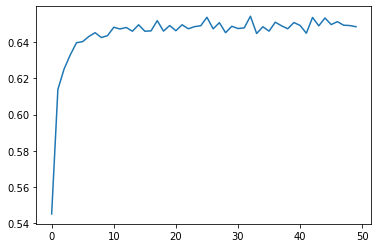

In [42]:
icons_tdm = ThreeDollarModel(X_icons_train.shape[1])
acc_ic = icons_tdm.decoder.fit(X_icons_train,Y_icons_train,epochs=50,verbose=1,shuffle=True,batch_size=32)

# plot the accuracy
plt.plot(acc_ic.history['accuracy'])

Epoch 1/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0529 - accuracy: 0.6501
Epoch 2/100
313/313 [==============================] - 7s 24ms/step - loss: 0.0529 - accuracy: 0.6545
Epoch 3/100
313/313 [==============================] - 7s 24ms/step - loss: 0.0529 - accuracy: 0.6509
Epoch 4/100
313/313 [==============================] - 9s 28ms/step - loss: 0.0528 - accuracy: 0.6559
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 0.0529 - accuracy: 0.6476
Epoch 6/100
313/313 [==============================] - 9s 27ms/step - loss: 0.0529 - accuracy: 0.6537
Epoch 7/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0528 - accuracy: 0.6510
Epoch 8/100
313/313 [==============================] - 6s 20ms/step - loss: 0.0528 - accuracy: 0.6521
Epoch 9/100
313/313 [==============================] - 6s 19ms/step - loss: 0.0528 - accuracy: 0.6519
Epoch 10/100
313/313 [==============================] - 6s 19ms/step - loss: 0.052

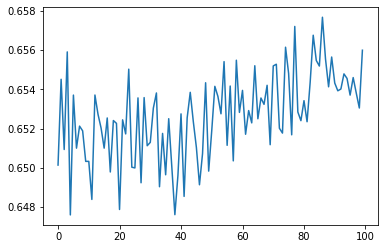

In [43]:
# extended training
acc_ic2 = icons_tdm.decoder.fit(X_icons_train,Y_icons_train,epochs=100,verbose=1,shuffle=True,batch_size=32)

# plot more
plt.plot(acc_ic2.history['accuracy'])

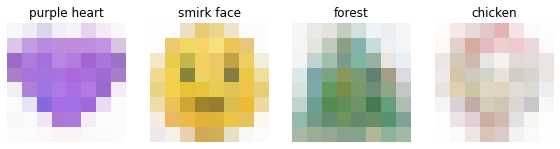

In [44]:
fave_emojis = ["purple heart", "smirk face", "forest", "chicken"]
RGB_OUT = []
for desc in fave_emojis:
    img = icons_tdm.txt2img(desc,False)
    #un-normalize the image
    img = (img*255).astype(np.uint8)
    RGB_OUT.append(img)

showMultiSprRGB(RGB_OUT,textArr=fave_emojis)

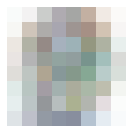

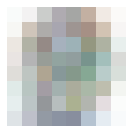

KeyboardInterrupt: Interrupted by user

In [45]:
user_in = input("Enter a description of an emoji: ")
while user_in != 'q':
    img = icons_tdm.txt2img(user_in,False)
    #un-normalize the image
    img = (img*255).astype(np.uint8)
    showMultiSprRGB([img],textArr=[user_in])
    user_in = input("Enter a description of an emoji: ")

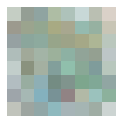

No chickens found


<Figure size 1440x504 with 0 Axes>

In [46]:
SPEC_EMOJI = "laptop"

#show output from model first
img = icons_tdm.txt2img(SPEC_EMOJI,False)
#un-normalize the image
img = (img*255).astype(np.uint8)
showSprRGB(img)

all_chickens = []
for i in icons50:
    ss = SPEC_EMOJI.split()
    f = 0
    for s in ss:
        if s not in i['label']:
            f = 1
            break
    if f == 0:
        all_chickens.append((i['img'],i['label']))
    

# all_chickens = [(i['img'],i['label']) for i in icons50 if SPEC_EMOJI ]

if len(all_chickens) == 0:
    print("No chickens found")

if len(all_chickens) > 32:
    for i in range(0,len(all_chickens),32):
        showMultiSprRGB([i[0] for i in all_chickens[i:i+32]],textArr=[i[1] for i in all_chickens[i:i+32]])
else:
    showMultiSprRGB([i[0] for i in all_chickens],textArr=[i[1] for i in all_chickens])

63


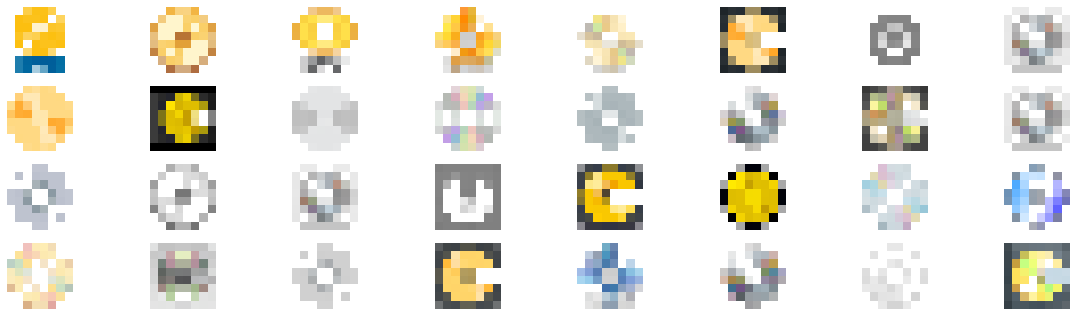

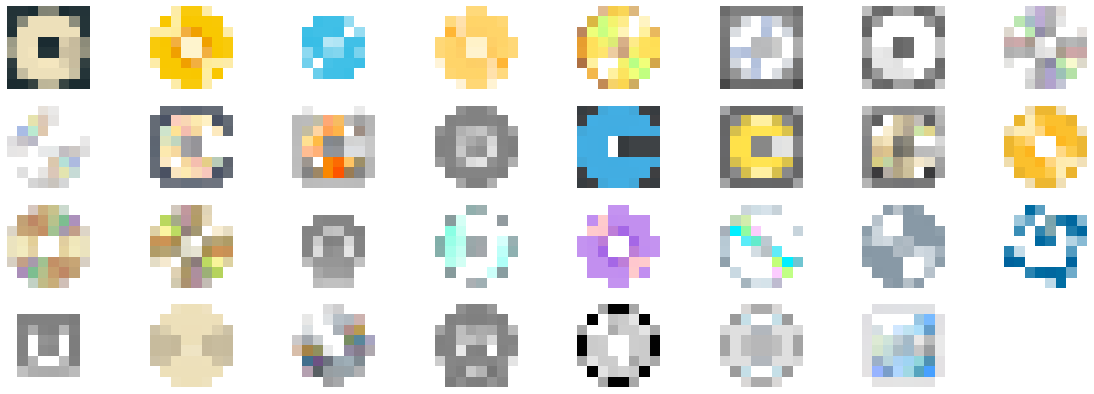

In [47]:
all_planes = [i['img'] for i in icons50 if "disk" in i['class']]
print(len(all_planes))

for i in range(0,len(all_planes),32):
    showMultiSprRGB(all_planes[i:i+32])

### Fix the bullshit icons dataset

In [48]:
uniq_icons = []
uniq_labels = []
for i in icons50:
    if i['label'] not in uniq_labels:
        uniq_icons.append(i['img'])
        uniq_labels.append(i['label'])

print(len(uniq_icons))

568


In [49]:

with tqdm(total=len(uniq_icons)) as pbar:
    X_uicons_train = []
    Y_uicons_train = []
    for i in uniq_icons:
        X_uicons_train.append(sentEmb(i['label']))
        Y_uicons_train.append((i['img'])/255)
        pbar.update(1)

    #convert to np
    X_uicons_train = np.array(X_uicons_train)
    Y_uicons_train = np.array(Y_uicons_train)


  0%|          | 0/568 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [50]:
# retrain model on unique icons
uicons_tdm = ThreeDollarModel(X_uicons_train.shape[1])
acc_uic = uicons_tdm.decoder.fit(X_uicons_train,Y_uicons_train,epochs=50,verbose=1,shuffle=True,batch_size=32)

# plot the accuracy
plt.plot(acc_uic.history['accuracy'])

AttributeError: 'list' object has no attribute 'shape'

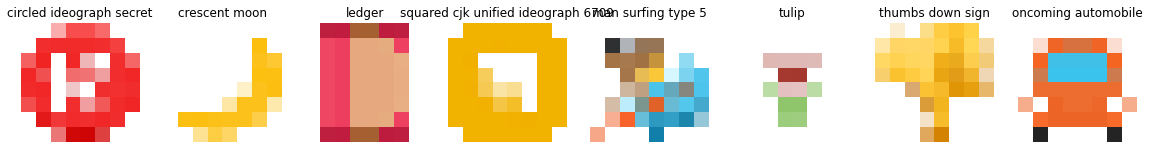

In [39]:
icons50 = np.load('../data/sprite_data/icon_dat_rgb8.npy', allow_pickle=True)
randicons = icons50[random.sample(range(0,len(icons50)), k=8)]
showMultiSprRGB([i['img'] for i in randicons],textArr=[i['label'] for i in randicons])

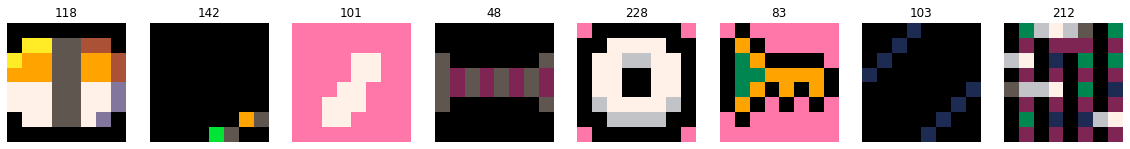

In [11]:
pico_sheets = np.load('../data/rip_data/good_pico_sheets.npy', allow_pickle=True)
pico_randicons = pico_sheets[random.sample(range(0,len(pico_sheets)), k=8)]
showMultiSprPalette([i['img'] for i in pico_randicons],textArr=[i['sprite_id'] for i in pico_randicons])

#### PATH OF DESTRUCTION